In [57]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.ndimage.filters import gaussian_filter1d
import pandasql as ps
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
from scipy.stats import f_oneway
from scipy.stats import ttest_ind

In [3]:
# Import dataset
file = r'C:\Users\Joel\Dropbox\Vitrual Internships\Quantium\Task 2\Data\QVI_clean_data.csv'
data = pd.read_csv(file, index_col= 0)
data

,real_date,STORE_NBR,TXN_ID,PROD_NAME,BRAND_NAME,PACKET_SIZE,PROD_QTY,TOT_SALES,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,AVG_CHIP_PRICE
0,2018-07-01,9,8808,Smiths Thinly Cut Roast Chicken 175g,Smiths,175,2,6.0,9341,RETIREES,Budget,3.0
1,2018-07-01,86,84237,Red Rock Deli Sp Salt & Truffle 150G,RRD,150,2,5.4,86016,RETIREES,Mainstream,2.7
2,2018-07-01,129,132474,Smith Crinkle Cut Mac N Cheese 150g,Smiths,150,2,5.2,129046,OLDER SINGLES/COUPLES,Premium,2.6
3,2018-07-01,58,53145,Pringles Sthrn FriedChicken 134g,Pringles,134,2,7.4,58072,OLDER SINGLES/COUPLES,Premium,3.7
4,2018-07-01,97,97311,WW Crinkle Cut Chicken 175g,Woolworths,175,2,3.4,97164,OLDER FAMILIES,Premium,1.7
...,...,...,...,...,...,...,...,...,...,...,...,...
246735,2019-06-30,91,89519,Thins Chips Seasonedchicken 175g,Thins,175,2,6.6,91076,YOUNG SINGLES/COUPLES,Mainstream,3.3
246736,2019-06-30,84,83704,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,84116,YOUNG SINGLES/COUPLES,Budget,4.4
246737,2019-06-30,24,20917,Smiths Crinkle Cut Chips Chs&Onion170g,Smiths,170,2,5.8,24115,YOUNG FAMILIES,Budget,2.9
246738,2019-06-30,199,198068,Doritos Corn Chips Nacho Cheese 170g,Doritos,170,2,8.8,199117,MIDAGE SINGLES/COUPLES,Mainstream,4.4


- First Task will be to establish a control store. The trial stores are 77, 86, and 88, so we must find potential stores which have similar performance to the trial stores.
- We can do this by looking at specifics metrics during the trail period of Feb 2019.

Metrics:
- Monthly sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

In [4]:
# Isolate stores which have been active throughout trial
data_active_feb = data[(data['real_date'] > '2019-02-01') & (data['real_date'] < '2019-04-01')]
data_active_feb['STORE_NBR'].value_counts()

active_stores = data_active_feb['STORE_NBR'].unique()
active_store_records = data[data.STORE_NBR.isin(active_stores)]

# Select all stores outside of trial stores BEFORE FEB
data_prior_feb = active_store_records[active_store_records['real_date'] < '2019-02-01']

query = """
        SELECT *
        FROM data_prior_feb
        WHERE STORE_NBR NOT IN (77, 86, 88)
        """
control_rec = ps.sqldf(query, locals())

# Create df of all stores outside of trial stores
# Create df of all stores active in febuary
stores = control_rec.STORE_NBR.unique()
control_stores = pd.DataFrame(stores, columns = ['STORE_NBR'])

# Add metrics to active stores

# Monthly Sales Rev
rev = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    rev.append(round(np.sum(df['TOT_SALES']), 2))

control_stores['TOT_SALES'] = rev

# Monthly Number of Customers
cust = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    cust.append(len(df.index))

control_stores['NBR_OF_CUST'] = cust

# Monthly number of transactions per customer
avg_qty = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    avg_qty.append(round(np.mean(df['PROD_QTY']), 2))

control_stores['AVG_QTY'] = avg_qty

# Average Unit price 
avg_unit = []
for store in control_stores['STORE_NBR']:
    df = control_rec[control_rec['STORE_NBR'] == store]
    avg_unit.append(round(np.mean(df['AVG_CHIP_PRICE']), 2))

control_stores['AVG_UNIT_PRICE' ] = avg_unit

control_stores

,STORE_NBR,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE
0,9,2297.40,373,1.76,3.51
1,129,5227.60,748,1.99,3.52
2,58,8576.95,994,1.99,4.35
3,97,5793.35,836,1.98,3.50
4,199,8200.50,943,1.98,4.39
...,...,...,...,...,...
257,244,176.60,31,1.58,3.58
258,258,156.20,23,1.96,3.50
259,117,91.80,27,1.04,3.29
260,252,3.70,1,1.00,3.70


In [5]:
# Create df for only trial stores BEFORE FEB

# Get only trial stores 77, 86, 88
query = """
        SELECT *
        FROM data_prior_feb
        WHERE STORE_NBR IN (77, 86, 88)
        """
trial_rec = ps.sqldf(query, locals())

# Create df of all trial stores 
stores = trial_rec.STORE_NBR.unique()
trial_stores = pd.DataFrame(stores, columns = ['STORE_NBR'])

# Add metrics to trial stores

# Monthly Sales Rev
rev = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    rev.append(round(np.sum(df['TOT_SALES']), 2))

trial_stores['TOT_SALES'] = rev

# Monthly Number of Customers
cust = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    cust.append(len(df.index))

trial_stores['NBR_OF_CUST'] = cust

# Monthly number of transactions per customer
avg_qty = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    avg_qty.append(round(np.mean(df['PROD_QTY']), 2))

trial_stores['AVG_QTY'] = avg_qty

# Average Unit price 
avg_unit = []
for store in trial_stores['STORE_NBR']:
    df = trial_rec[trial_rec['STORE_NBR'] == store]
    avg_unit.append(round(np.mean(df['AVG_CHIP_PRICE']), 2))

trial_stores['AVG_UNIT_PRICE' ] = avg_unit

trial_stores

,STORE_NBR,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE
0,86,5795.65,832,1.99,3.51
1,88,8832.80,1028,1.98,4.33
2,77,1595.50,298,1.52,3.56


Before writing the function to choose comparable control stores, we must first define what metric we will use. Our test metric will be if all the features (total sales, number of customers etc.) are within 5% of the trial store's feature value.

For example:
- Total sales, number of customers, average quantity, and average unit price of the potential control store, must be within 5% of the same feature's value in the trial store.

- If the trial store is Store 86:
    - Total sales: 5795.65
    - Number of customers: 832
    - Average Quantity: 1.99
    - Average Unit Price: 3.51

- Then the control store candidate must be within these parameters:
    - Total sales: Within 5505.9 & 6084.75
    - Number of customers: Within 791.4 & 873
    - Average Quantity: Within 1.89 & 2.09
    - Average Unit Price: Within 3.33 & 3.68


In [7]:
# Writing Function to choose store
def compare_stores(trial_df, control_df):
    columns = ['TOT_SALES', 'NBR_OF_CUST', 'AVG_QTY', 'AVG_UNIT_PRICE']
    similar_stores = []
    trial_store_compared = []
    for store in trial_df.index:
        for x in control_df.index:
            score = 0
            for feature in columns:
                if (control_df.loc[x][feature] >= (0.95 * trial_df.loc[store][feature])) & (control_df.loc[x][feature] <= (1.05 * trial_df.loc[store][feature])):
                    score += 1
            
            if score == 4:
                similar_stores.append(control_df.loc[x]['STORE_NBR'])
                trial_store_compared.append(store)

    comparison = pd.DataFrame(trial_store_compared, columns = ['trial_store'])
    comparison['Control_store_candidate'] = similar_stores
    comparison['trial_store'].replace({0:86, 1:88, 2:77}, inplace = True)
    
    store_86_df = comparison[comparison['trial_store'] == 86]
    store_88_df = comparison[comparison['trial_store'] == 88]
    store_77_df = comparison[comparison['trial_store'] == 77]

    # Select at random, control store for each trial store
    store_86_control = store_86_df.sample(1, random_state = 7)
    store_88_control = store_88_df.sample(1, random_state = 23)
    store_77_control = store_77_df.sample(1, random_state = 117)

    control_stores = pd.concat([store_77_control, store_86_control, store_88_control])
    return control_stores


In [8]:
compare_stores(trial_stores, control_stores)

,trial_store,Control_store_candidate
41,77,233.0
32,86,67.0
37,88,165.0


Our sample has chosen the following control stores for corresponding trial stores:

- The Store 77 Control store = Store 233
- The Store 86 Control store = Store 67
- The Store 88 Control store = Store 165

In [9]:
# Create comparison DF
trial_store_77 = trial_stores[trial_stores['STORE_NBR'] == 77]
control_store_77 = control_stores[control_stores['STORE_NBR'] == 233]
trial_store_86 = trial_stores[trial_stores['STORE_NBR'] == 86]
control_store_86 = control_stores[control_stores['STORE_NBR'] == 67]
trial_store_88 = trial_stores[trial_stores['STORE_NBR'] == 88]
control_store_88 = control_stores[control_stores['STORE_NBR'] == 165]

comparison_df = pd.concat([trial_store_77,control_store_77,trial_store_86,control_store_86,trial_store_88,control_store_88])

# Transpose DF
comparison_df = comparison_df

# Rename Columns

comparison_df['Metrics'] = [
    'Trial_store_77',
    'Control_store_77',
    'Trial_store_86',
    'Control_store_86',
    'Trial_store_88',
    'Control_store_88']

comparison_df.set_index('Metrics', inplace = True)

comparison_df.T

Metrics,Trial_store_77,Control_store_77,Trial_store_86,Control_store_86,Trial_store_88,Control_store_88
STORE_NBR,77.00,233.00,86.00,67.00,88.00,165.00
TOT_SALES,1595.50,1534.50,5795.65,5601.20,8832.80,8748.20
NBR_OF_CUST,298.00,285.00,832.00,798.00,1028.00,999.00
AVG_QTY,1.52,1.54,1.99,1.99,1.98,1.99
AVG_UNIT_PRICE,3.56,3.50,3.51,3.53,4.33,4.40


In [10]:
trial_stores.sort_values(by = 'STORE_NBR', inplace = True)
trial_stores

,STORE_NBR,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE
2,77,1595.50,298,1.52,3.56
0,86,5795.65,832,1.99,3.51
1,88,8832.80,1028,1.98,4.33


In [11]:
control_stores_df = pd.concat([control_store_77, control_store_86, control_store_88])
control_stores_df

,STORE_NBR,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE
203,233,1534.5,285,1.54,3.50
192,67,5601.2,798,1.99,3.53
20,165,8748.2,999,1.99,4.40


In [12]:
plot_comparison_df = trial_stores
plot_comparison_df = pd.concat([trial_stores, control_store_77, control_store_86, control_store_88], axis = 0)
plot_comparison_df['Label'] = ['Trial Store', 'Trial Store', 'Trial Store', 'Control Store', 'Control Store', 'Control Store']
plot_comparison_df.reset_index(drop = True, inplace = True)
plot_comparison_df = plot_comparison_df.reindex([0,3,1,4,2,5])
plot_comparison_df['Name'] = ['Store 77','Store 77','Store 86','Store 86','Store 88','Store 88',]
plot_comparison_df

,STORE_NBR,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE,Label,Name
0,77,1595.50,298,1.52,3.56,Trial Store,Store 77
3,233,1534.50,285,1.54,3.50,Control Store,Store 77
1,86,5795.65,832,1.99,3.51,Trial Store,Store 86
4,67,5601.20,798,1.99,3.53,Control Store,Store 86
2,88,8832.80,1028,1.98,4.33,Trial Store,Store 88
5,165,8748.20,999,1.99,4.40,Control Store,Store 88


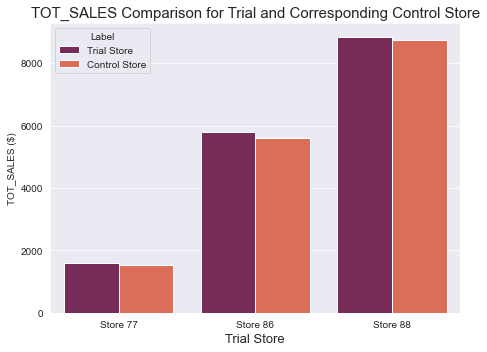

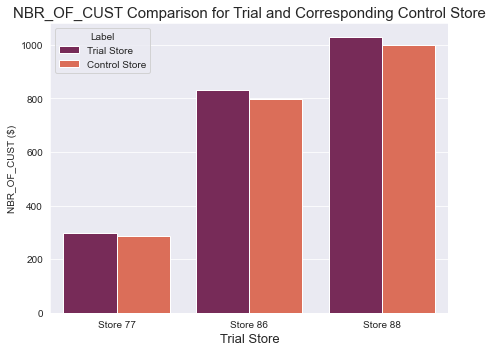

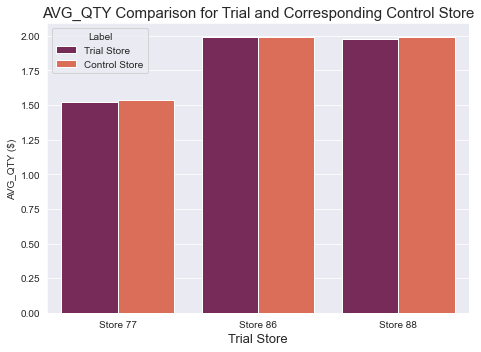

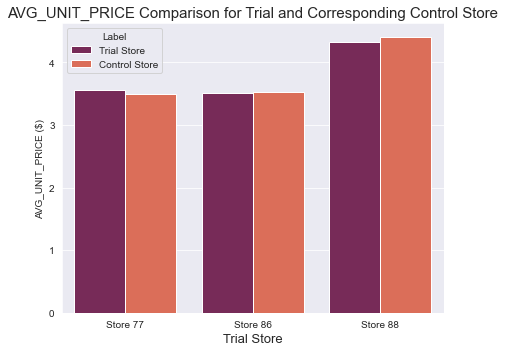

In [13]:
# Visualize trial vs control store metrics to see if theyre similar

columns = ['TOT_SALES', 'NBR_OF_CUST', 'AVG_QTY', 'AVG_UNIT_PRICE']

for metric in columns:
    if metric == 'TOT_SALES' or 'AVG_UNIT_PRICE':
        plt.figure(figsize=(7,5))
        ax = sns.set_style('darkgrid')
        ax = sns.barplot(x = 'Name', y = metric, data = plot_comparison_df,hue='Label', palette = 'rocket')
        ax.set_xlabel('Trial Store', fontsize = 13)
        ax.set_ylabel( f'{metric} ($)')
        ax.axes.set_title(f'{metric} Comparison for Trial and Corresponding Control Store', fontsize = 15)
        plt.xticks()
        plt.yticks()
        plt.tight_layout()
    
    else:
        plt.figure(figsize=(7,5))
        ax = sns.set_style('darkgrid')
        ax = sns.barplot(x = 'Name', y = metric, data = plot_comparison_df,hue='Label', palette = 'rocket')
        ax.set_xlabel('Trial Store')
        ax.set_ylabel(metric)
        ax.axes.set_title(f'{metric} Comparison for Trial and Corresponding Control Store', fontsize = 15)
        plt.xticks()
        plt.yticks()
        plt.tight_layout()


We can see from our visualizations that the control group closely matches the performance of the corresponding trial group in all aspects, prior to the trial period.

To refresh:
- The Store 77 Control store = Store 233
- The Store 86 Control store = Store 67
- The Store 88 Control store = Store 165


Now that we have our trial and control stores, we can now assess the performance of the trial period and the effect of the changes on the trial stores, and compare them to the control stores.

To begin, lets gather the control and trial store data just prior to the trial period.

Since the trial period is 2 months long (feb to apr), we will need data from 2 months prior to the trial. However, we cannot use december as our comparison, due to the fact that sales in December contain outliers, therefore, we will combine transaction data for the stores in November 2018 and January 2019.

In [33]:
pre_trial_jan = active_store_records[(active_store_records['real_date'] < '2019-02-01') & (active_store_records['real_date'] > '2019-01-01')]

# Gather trial and control stores jan and nov
query = """
        SELECT *
        FROM pre_trial_jan
        WHERE STORE_NBR IN (77, 86, 88, 233, 67, 165)
        """
pre_trial_rec_jan = ps.sqldf(query, locals())

pre_trial_nov = active_store_records[(active_store_records['real_date'] < '2018-12-01') & (active_store_records['real_date'] > '2018-11-01')]

query = """
        SELECT *
        FROM pre_trial_nov
        WHERE STORE_NBR IN (77, 86, 88, 233, 67, 165)
        """

pre_trial_rec_nov = ps.sqldf(query,locals())

# combine jan and nov into one df
pre_trial_rec = pd.concat([pre_trial_rec_jan, pre_trial_rec_nov])


# Create df of all stores pre_trial
stores = pre_trial_rec.STORE_NBR.unique()
pre_trial_data = pd.DataFrame(stores, columns = ['STORE_NBR'])

# Add metrics to active stores

# Sales Rev Jan
rev = []

# Number of Customers
cust = []

# Avg Qty
avg_qty = []

# Avg Unit Price
avg_unit = []

for store in pre_trial_data['STORE_NBR']:
    df = pre_trial_rec[pre_trial_rec['STORE_NBR'] == store]
    rev.append(round(np.sum(df['TOT_SALES']), 2))
    cust.append(len(df.index))
    avg_qty.append(round(np.mean(df['PROD_QTY']), 2))
    avg_unit.append(round(np.mean(df['AVG_CHIP_PRICE']), 2))
    
pre_trial_data['TOT_SALES'] = rev
pre_trial_data['NBR_OF_CUST'] = cust
pre_trial_data['AVG_QTY'] = avg_qty
pre_trial_data['AVG_UNIT_PRICE'] = avg_unit

pre_trial_data = pre_trial_data.reindex([5,2,4,3,1,0])
pre_trial_data['TYPE'] = ['Trial Store', 'Control Store', 'Trial Store', 'Control Store', 'Trial Store', 'Control Store']
pre_trial_data['Name'] = ['Store 77','Store 77','Store 86','Store 86','Store 88','Store 88']
pre_trial_data = pre_trial_data.set_index('STORE_NBR')
pre_trial_data 



,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE,TYPE,Name
STORE_NBR,,,,,,
77,413.3,77,1.57,3.48,Trial Store,Store 77
233,328.6,65,1.42,3.58,Control Store,Store 77
86,1602.0,233,2.00,3.44,Trial Store,Store 86
67,1573.6,228,2.00,3.45,Control Store,Store 86
88,2449.8,282,2.00,4.34,Trial Store,Store 88
165,2479.2,285,1.99,4.37,Control Store,Store 88


- Again, we can be reassured that the metric statistics for the trial stores and their corresponding control stores are very similar for the month of January.
- The above statistics are for the months of January and November the previous year.

The trial period goes from the start of Feb 2019 to Apr 2019. We want to see if there has been an uplift in overall chip sales. We will start with scaling the control store's sales to a similar level to control for any differences between the two stores outside of the trial period.

In [40]:
pre_trial_scaled = pre_trial_data
pre_trial_scaled

,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE,TYPE,Name
STORE_NBR,,,,,,
77,413.3,77,1.57,3.48,Trial Store,Store 77
233,328.6,65,1.42,3.58,Control Store,Store 77
86,1602.0,233,2.00,3.44,Trial Store,Store 86
67,1573.6,228,2.00,3.45,Control Store,Store 86
88,2449.8,282,2.00,4.34,Trial Store,Store 88
165,2479.2,285,1.99,4.37,Control Store,Store 88


In [42]:
trial_stores = [77, 86, 88]
control_stores = [233, 67, 165]

scaling_factors = []

# Get scaling factors for tot_sales
for trial_store, control_store in zip(trial_stores, control_stores):
    df = pre_trial_rec[pre_trial_rec['STORE_NBR'] == trial_store]
    df2 = pre_trial_rec[pre_trial_rec['STORE_NBR'] == control_store]
    tot_sales_trial = np.sum(df['TOT_SALES'])
    tot_sales_control = np.sum(df2['TOT_SALES'])
    scaler = tot_sales_trial / tot_sales_control
    scaling_factors.append(round(scaler,2))
    
for control_store, scaler in zip(control_stores, scaling_factors):
    new_value = round((pre_trial_data[pre_trial_data.index == control_store]['TOT_SALES']) * scaler, 1)
    pre_trial_scaled.at[control_store, 'TOT_SALES'] = new_value

pre_trial_scaled
    

,TOT_SALES,NBR_OF_CUST,AVG_QTY,AVG_UNIT_PRICE,TYPE,Name
STORE_NBR,,,,,,
77,413.3,77,1.57,3.48,Trial Store,Store 77
233,414.0,65,1.42,3.58,Control Store,Store 77
86,1602.0,233,2.00,3.44,Trial Store,Store 86
67,1605.1,228,2.00,3.45,Control Store,Store 86
88,2449.8,282,2.00,4.34,Trial Store,Store 88
165,2454.4,285,1.99,4.37,Control Store,Store 88


Now that we have scaled figures for the baseline (pre_trial), we can scale the actual transactions for the trial period.

In [51]:
scaled_trial_data = pre_trial_scaled[['TYPE','TOT_SALES']]
scaled_trial_data['SCALING_FACTOR'] = [0, 1.26, 0, 1.02, 0, 0.99]
scaled_trial_data

<ipython-input-51-0c761027fcf2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_trial_data['SCALING_FACTOR'] = [0, 1.26, 0, 1.02, 0, 0.99]


,TYPE,TOT_SALES,SCALING_FACTOR
STORE_NBR,,,
77,Trial Store,413.3,0.00
233,Control Store,414.0,1.26
86,Trial Store,1602.0,0.00
67,Control Store,1605.1,1.02
88,Trial Store,2449.8,0.00
165,Control Store,2454.4,0.99


In [73]:
# Gather data for period of the trial
trial_period_data = data[(data['real_date'] > '2019-02-01') & (data['real_date'] < '2019-04-01')]
trial_period_data

# select only control stores
query = """
        SELECT *
        FROM trial_period_data
        WHERE STORE_NBR IN (233, 67, 165)
        """
control_store_trial_data = ps.sqldf(query,locals())

trial_stores = [77, 86, 88]
control_stores = [233, 67, 165]


scaled_tot_sales = []

for trial_store, control_store, scaler in zip(trial_stores, control_stores, scaling_factors):
    
    # Trial store sales
    trial_df = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]
    trial_tot_sales = round(np.sum(trial_df['TOT_SALES']), 2)
    scaled_tot_sales.append(trial_tot_sales)
    
    # Scaling the control store sales
    control_df = trial_period_data[trial_period_data['STORE_NBR'] == control_store]
    control_df['TOT_SALES'] = control_df['TOT_SALES'] * scaler
    control_tot_sales = round(np.sum(control_df['TOT_SALES']), 2)
    scaled_tot_sales.append(control_tot_sales)
    
scaled_trial_data['TOT_SALES'] = scaled_tot_sales

# Create Comparison DF
comparison = pre_trial_scaled[['TYPE', 'TOT_SALES']]
comparison.rename(columns = {'TOT_SALES': 'PRE_TRIAL_SALES'}, inplace = True)
comparison['TRIAL_SALES'] = scaled_trial_data['TOT_SALES']

# Get Percentage Change
comparison['%_CHANGE'] = round(((comparison['TRIAL_SALES'] - comparison['PRE_TRIAL_SALES']) / comparison['PRE_TRIAL_SALES']) * 100, 2)

# Percentage differential
comparison['%_DIFFERENCE'] = 0
differential = []
for i,x in zip(trial_stores,control_stores):
    diff_trial = round(((comparison.at[i, 'TRIAL_SALES'] - comparison.at[x, 'TRIAL_SALES']) / comparison.at[x, 'TRIAL_SALES'])*100,2)
    diff_control = round(((comparison.at[x, 'TRIAL_SALES'] - comparison.at[i, 'TRIAL_SALES']) / comparison.at[x, 'TRIAL_SALES'])*100,2)
    differential.append(diff_trial)
    differential.append(diff_control)
comparison['%_DIFFERENCE'] = differential

for i in control_stores:
    comparison.at[i, '%_DIFFERENCE'] = 0
    
comparison['TRIAL_STORE'] = ['Store 77', 'Store 77', 'Store 86', 'Store 86', 'Store 88', 'Store 88']
comparison

,TYPE,PRE_TRIAL_SALES,TRIAL_SALES,%_CHANGE,%_DIFFERENCE,TRIAL_STORE
STORE_NBR,,,,,,
77,Trial Store,413.3,455.70,10.26,-7.48,Store 77
233,Control Store,414.0,492.53,18.97,0.00,Store 77
86,Trial Store,1602.0,1799.60,12.33,14.36,Store 86
67,Control Store,1605.1,1573.66,-1.96,0.00,Store 86
88,Trial Store,2449.8,2752.60,12.36,22.89,Store 88
165,Control Store,2454.4,2239.88,-8.74,0.00,Store 88


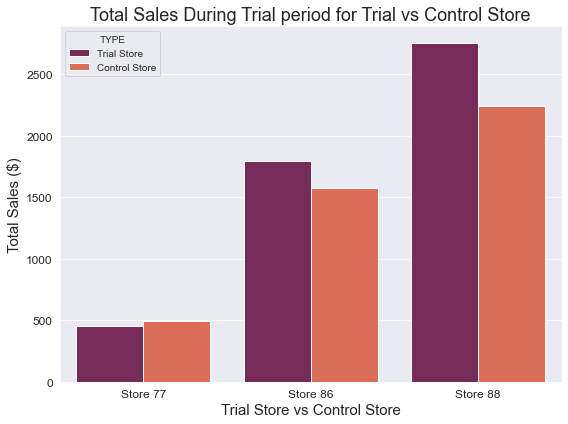

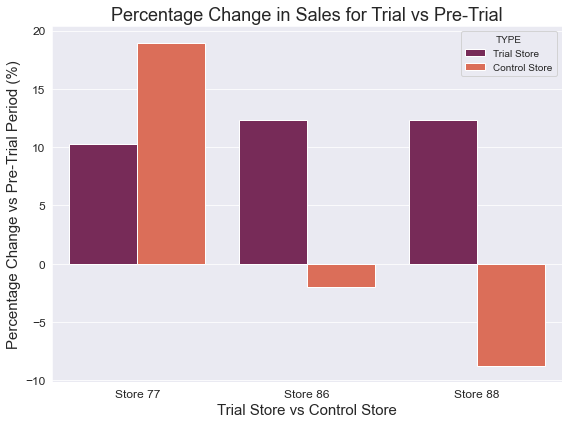

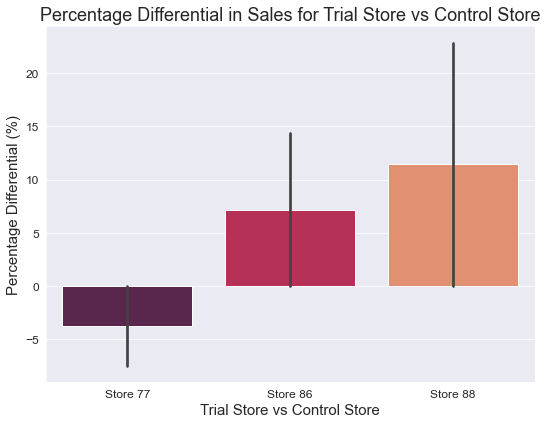

In [80]:
# Plotting results

# Total Sales
plt.figure(figsize = (8,6))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = 'TRIAL_STORE', y = 'TRIAL_SALES', data = comparison, hue = 'TYPE', palette = 'rocket')
ax.set_xlabel('Trial Store vs Control Store', fontsize = 15)
ax.set_ylabel('Total Sales ($)', fontsize = 15)
ax.axes.set_title('Total Sales During Trial period for Trial vs Control Store', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

# % Change compared to pre-trial period
plt.figure(figsize = (8,6))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = 'TRIAL_STORE', y = '%_CHANGE', data = comparison, hue = 'TYPE', palette = 'rocket')
ax.set_xlabel('Trial Store vs Control Store', fontsize = 15)
ax.set_ylabel('Percentage Change vs Pre-Trial Period (%)', fontsize = 15)
ax.axes.set_title('Percentage Change in Sales for Trial vs Pre-Trial', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

# % Differential of sales for Trial Store vs Control Store
plt.figure(figsize = (8,6))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = 'TRIAL_STORE', y = '%_DIFFERENCE', data = comparison, palette = 'rocket')
ax.set_xlabel('Trial Store vs Control Store', fontsize = 15)
ax.set_ylabel('Percentage Differential (%)', fontsize = 15)
ax.axes.set_title('Percentage Differential in Sales for Trial Store vs Control Store', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

Now that we have our results, we can see that 2/3 trial stores were able to have total sales increase over their corresponding control store. Similarly, those same stores were the only ones to have a higher percentage change in sales from pre-trial, over to the trial, higher than their control counterpart. 

- Trial store 77 did not see a percentage increase higher than it's control store.
- Trial stores 86 and 88 did see an increase in sales compared to their control stores.

We see that stores 86 and 88 are the only stores during the trial to have a significant positive percentage differential over their control counterparts. 

Let's check if the difference is significant by doing a T test. Our first test will have a null hypothesis being that the trial period is the same as the pre-trial period. 

First we will look at their distributions.

In [98]:
scaled_trial_data

,TYPE,TOT_SALES,SCALING_FACTOR
STORE_NBR,,,
77,Trial Store,455.70,0.00
233,Control Store,492.53,1.26
86,Trial Store,1799.60,0.00
67,Control Store,1573.66,1.02
88,Trial Store,2752.60,0.00
165,Control Store,2239.88,0.99


In [107]:
def create_scaled_sales_pre_trial_isolated_df(store, scaler):
    sub_df = pre_trial_rec
    query = f"SELECT * FROM sub_df WHERE STORE_NBR = {store}"
    df = ps.sqldf(query, locals())
    df['TOT_SALES'] = df['TOT_SALES'] * scaler
    return df

def create_trial_sales_pre_trial_isolated_df(store):
    sub_df = pre_trial_rec
    query = f"SELECT * FROM sub_df WHERE STORE_NBR = {store}"
    df = ps.sqldf(query, locals())
    return df

def create_trial_isolation_df(store):
    sub_df = trial_period_data
    query = f"SELECT * FROM sub_df WHERE STORE_NBR = {store}"
    df = ps.sqldf(query, locals())
    return df

def create_trial_control_isolation_df(store, scaler):
    sub_df = trial_period_data
    query = f"SELECT * FROM sub_df WHERE STORE_NBR = {store}"
    df = ps.sqldf(query, locals())
    df['TOT_SALES'] = df['TOT_SALES'] * scaler
    return df

# Display Distributions

def compare_distributions(trial, pre_trial, store):
    plt.figure(figsize = (8,6))
    ax1 = sns.histplot(trial['TOT_SALES'])
    ax2 = sns.histplot(pre_trial['TOT_SALES'], color = 'orange')
    plt.axvline(np.mean(trial['TOT_SALES']), color = 'b', linestyle = 'dashed', linewidth = 2)
    plt.axvline(np.mean(pre_trial['TOT_SALES']), color = 'red', linestyle = 'dashed', linewidth = 2)
    _, max_ = plt.ylim()
    plt.text(
        trial['TOT_SALES'].mean() + trial['TOT_SALES'].mean() / 10,
        max_ - max_ / 5,
        "Trial Period Mean: {:.2f}".format(trial['TOT_SALES'].mean())
    )

    _, max_ = plt.ylim()
    plt.text(
        pre_trial['TOT_SALES'].mean() + pre_trial['TOT_SALES'].mean() / 10,
        max_ - max_ / 6,
        "Pre-Trial Period Mean: {:.2f}".format(pre_trial['TOT_SALES'].mean())
    )
    plt.xlabel('SALES ($)', fontsize = 12)
    plt.title(f'Sales Per Transaction Distribution Comparison for Trial vs Pre-Trial for store {store}', fontsize = 15)
    plt.legend(['Trial Period', 'Pre-Trial Period'], loc = 'best')


def compare_trial_period_distributions(trial, pre_trial, store):
    plt.figure(figsize = (8,6))
    ax1 = sns.histplot(trial['TOT_SALES'])
    ax2 = sns.histplot(pre_trial['TOT_SALES'], color = 'maroon')
    plt.axvline(np.mean(trial['TOT_SALES']), color = 'b', linestyle = 'dashed', linewidth = 2)
    plt.axvline(np.mean(pre_trial['TOT_SALES']), color = 'maroon', linestyle = 'dashed', linewidth = 2)
    _, max_ = plt.ylim()
    plt.text(
        trial['TOT_SALES'].mean() + trial['TOT_SALES'].mean() / 10,
        max_ - max_ / 5,
        "Trial Store Mean: {:.2f}".format(trial['TOT_SALES'].mean())
    )

    _, max_ = plt.ylim()
    plt.text(
        pre_trial['TOT_SALES'].mean() + pre_trial['TOT_SALES'].mean() / 10,
        max_ - max_ / 6,
        "Control Store Mean: {:.2f}".format(pre_trial['TOT_SALES'].mean())
    )
    plt.xlabel('SALES ($)', fontsize = 12)
    plt.title(f'Sales Per Transaction Distribution Comparison, Trial Store {store} vs Control Store', fontsize = 15)
    plt.legend(['Trial Store', 'Control Store'], loc = 'best')

# Pre Trial df's

pre_trial_77 = create_trial_sales_pre_trial_isolated_df(77)
pre_trial_233 = create_scaled_sales_pre_trial_isolated_df(233, 1.26)

pre_trial_86 = create_trial_sales_pre_trial_isolated_df(86)
pre_trial_67 = create_scaled_sales_pre_trial_isolated_df(67, 1.02)

pre_trial_88 = create_trial_sales_pre_trial_isolated_df(88)
pre_trial_165 = create_scaled_sales_pre_trial_isolated_df(165, 0.99)

# Trial period df's
trial_77 = create_trial_isolation_df(77)
trial_233 = create_trial_control_isolation_df(233, 1.26)

trial_86 = create_trial_isolation_df(86)
trial_67 = create_trial_control_isolation_df(67, 1.02)

trial_88 = create_trial_isolation_df(88)
trial_165 = create_trial_control_isolation_df(165, 0.99)

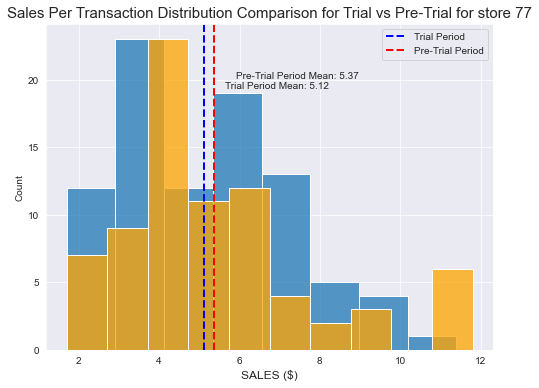

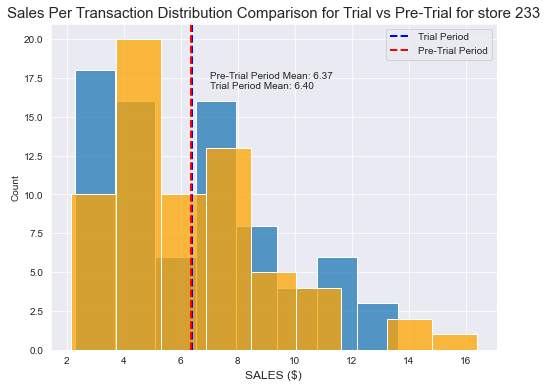

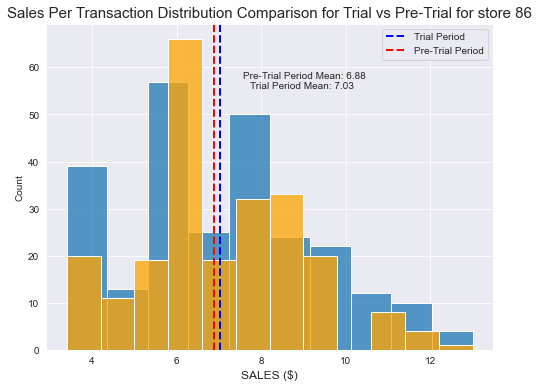

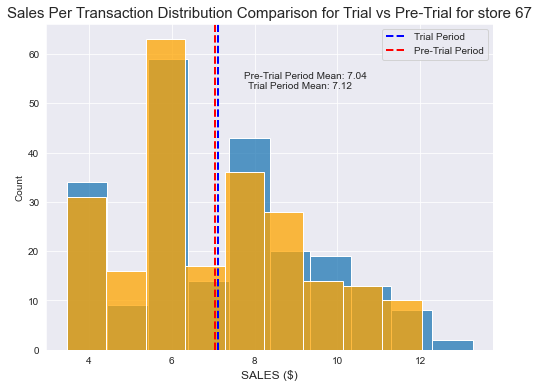

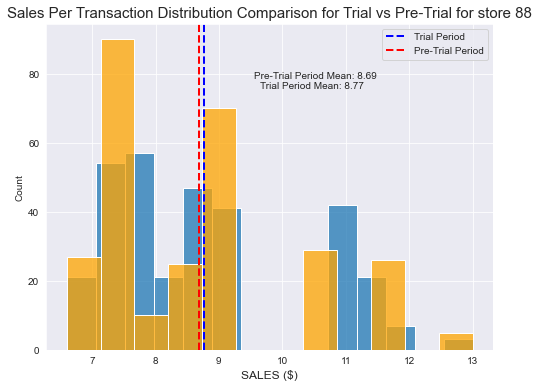

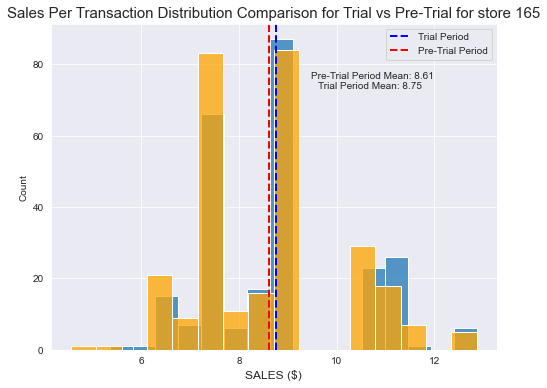

In [108]:
# Display Distributions for trial vs pre_trial

trial_dfs = [trial_77, trial_233, trial_86, trial_67, trial_88, trial_165]
pre_trial_dfs = [pre_trial_77, pre_trial_233, pre_trial_86, pre_trial_67, pre_trial_88, pre_trial_165]
stores = [77,233,86,67,88,165]

for trial, pre_trial, store in zip(trial_dfs, pre_trial_dfs, stores):
    compare_distributions(trial, pre_trial, store)

In [109]:
# compare 2 groups func
def compare_2_groups(arr_1, arr_2, alpha, sample_size):
    stat, p = ttest_ind(arr_1, arr_2)
    print('Statistics = %.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

In [171]:
# Perform T-Test
sample_size = 50

# Store 77
store_77_pre_trial_sampled = np.random.choice(pre_trial_77['TOT_SALES'], sample_size)
store_77_trial_sampled = np.random.choice(trial_77['TOT_SALES'], sample_size)

# Store 77 trial vs pre_trial
compare_2_groups(store_77_pre_trial_sampled, store_77_trial_sampled, 0.05, sample_size)

Statistics = 2.316, p=0.023
Different distributions (reject H0)


In [134]:
# Store 86
store_86_pre_trial_sampled = np.random.choice(pre_trial_86['TOT_SALES'], sample_size)
store_86_trial_sampled = np.random.choice(trial_86['TOT_SALES'], sample_size)

# Store 86 trial vs pre_trial
compare_2_groups(store_86_pre_trial_sampled, store_86_trial_sampled, 0.05, sample_size)

Statistics = 2.389, p=0.024
Different distributions (reject H0)


In [136]:
# Store 88
store_88_pre_trial_sampled = np.random.choice(pre_trial_88['TOT_SALES'], sample_size)
store_88_trial_sampled = np.random.choice(trial_88['TOT_SALES'], sample_size)

# Store 88 trial vs pre_trial
compare_2_groups(store_88_pre_trial_sampled, store_88_trial_sampled, 0.05, sample_size)

Statistics = -2.232, p=0.034
Different distributions (reject H0)


Great! We see that there is a significant difference between the distributions of the trial stores during the trial period and outside the trial period.

We will next run a test to see if the difference between the trial and control stores during the trial period are significantly different. We will first look at the distributions as previous, then run a t test on the 3 pairs of stores.

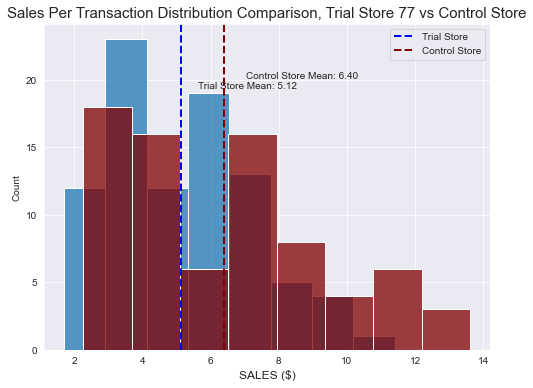

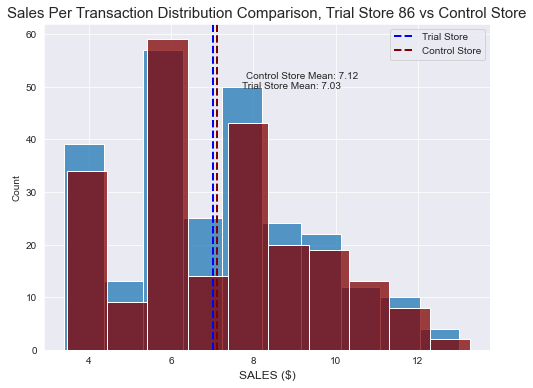

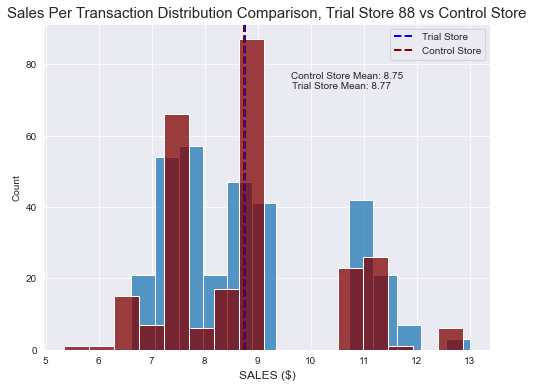

In [137]:
# Display distributions of trial and control stores during trial period.

trial_store_dfs = [trial_77, trial_86, trial_88]
trial_control_dfs = [trial_233, trial_67, trial_165]
stores = [77, 86, 88]

for trial, control, store in zip(trial_store_dfs, trial_control_dfs, stores):
    compare_trial_period_distributions(trial, control, store)

Now we can run a T-test with a null hypothesis being that the sales in the trial store is not significantly different from it's control store.

In [159]:
# Perform T-test
sample_size = 50

# Store 77
store_77_trial_sampled = np.random.choice(trial_77['TOT_SALES'], sample_size)
store_233_trial_sampled = np.random.choice(trial_233['TOT_SALES'], sample_size)

compare_2_groups(store_77_trial_sampled, store_233_trial_sampled, 0.05, sample_size)

Statistics = -2.092, p=0.039
Different distributions (reject H0)


In [314]:
# Store 86
sample_size = 50
store_86_trial_sampled = np.random.choice(trial_86['TOT_SALES'], sample_size)
store_67_trial_sampled = np.random.choice(trial_67['TOT_SALES'], sample_size)

compare_2_groups(store_86_trial_sampled, store_67_trial_sampled, 0.05, sample_size)

Statistics = -1.002, p=0.319
Same distribution (fail to reject H0)


In [168]:
# Store 88
store_88_trial_sampled = np.random.choice(trial_88['TOT_SALES'], sample_size)
store_165_trial_sampled = np.random.choice(trial_165['TOT_SALES'], sample_size)

compare_2_groups(store_88_trial_sampled, store_165_trial_sampled, 0.05, sample_size)

Statistics = 2.762, p=0.007
Different distributions (reject H0)


Let's visualize the sales of the trial and the control stores to see how different they are.

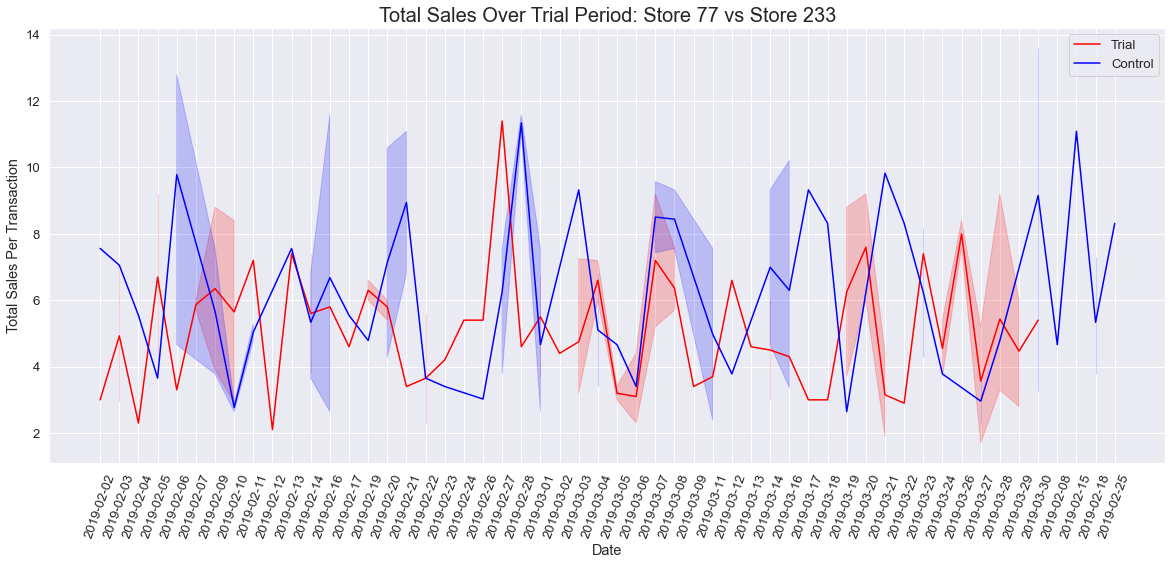

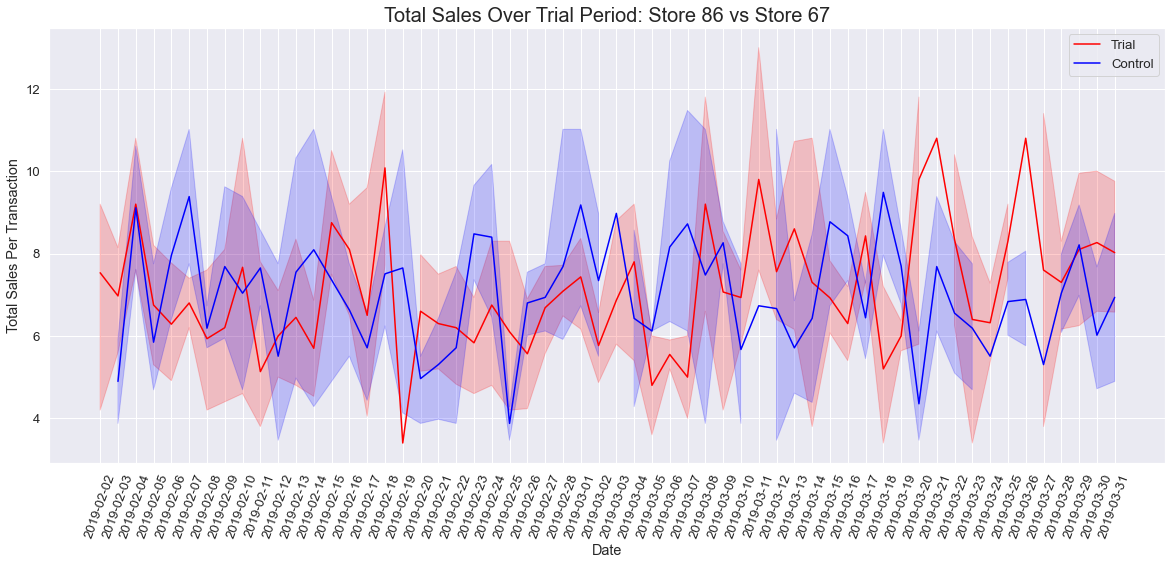

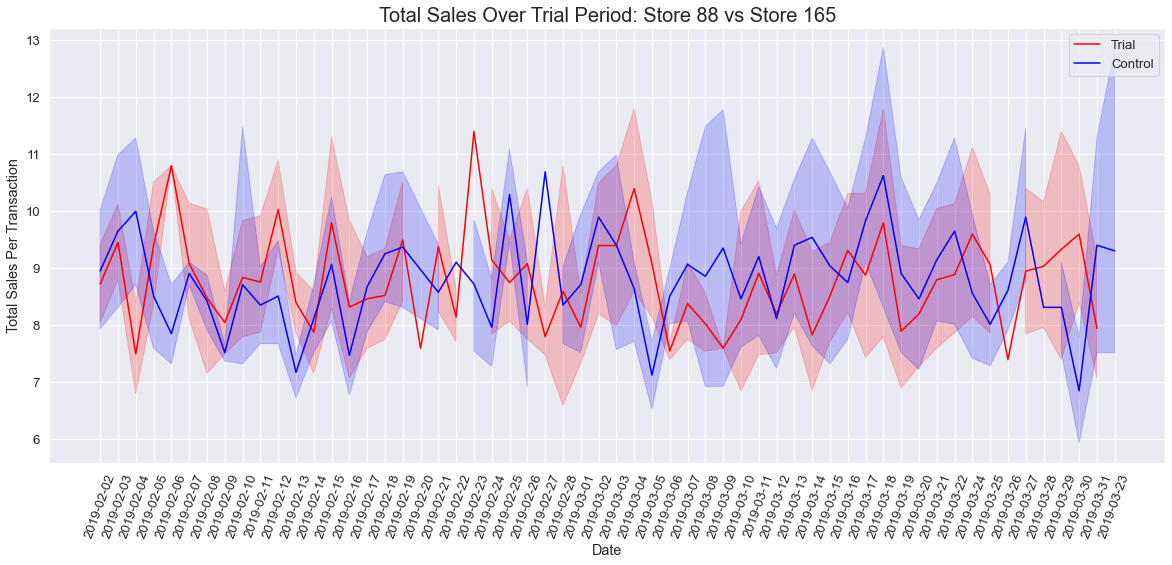

In [188]:
def plot_difference(trial, control, trial_store, control_store):
    plt.figure(figsize = (20,8))
    sns.set_style('darkgrid')
    sns.set_context('notebook', font_scale = 1.2)
    sns.lineplot(data = trial, x = 'real_date', y = 'TOT_SALES', palette = 'rocket', color = 'r')
    sns.lineplot(data = control, x = 'real_date', y = 'TOT_SALES', palette = 'rocket', color = 'b')
    plt.xlabel('Date')
    plt.ylabel('Total Sales Per Transaction')
    plt.title(f'Total Sales Over Trial Period: {trial_store} vs {control_store}', fontsize = 20)
    plt.legend(['Trial', 'Control'])
    plt.xticks(rotation = 70)
    
plot_difference(trial_77, trial_233, 'Store 77', 'Store 233')
plot_difference(trial_86, trial_67, 'Store 86', 'Store 67')
plot_difference(trial_88, trial_165, 'Store 88', 'Store 165')

Now that we have our data and assessment of the trial on total sales, we can do the same for number of customers.

In [199]:
# Scaling the pre_trial number of customers for the control stores

pre_trial_customers_scaled = pre_trial_data[['NBR_OF_CUST', 'TYPE']]

trial_stores = [77, 86, 88]
control_stores = [233, 67, 165]

scaling_factors = []

for trial_store, control_store in zip(trial_stores, control_stores):
    df = pre_trial_rec[pre_trial_rec['STORE_NBR'] == trial_store]
    df2 = pre_trial_rec[pre_trial_rec['STORE_NBR'] == control_store]
    cust_trial = len(df)
    cust_control = len(df2)
    scaler = cust_trial / cust_control
    scaling_factors.append(round(scaler,2))
    
for control_store, scaler in zip(control_stores, scaling_factors):
    new_value = round((pre_trial_data[pre_trial_data.index == control_store]['NBR_OF_CUST']) * scaler, 1)
    pre_trial_customers_scaled.at[control_store, 'NBR_OF_CUST'] = new_value
    
pre_trial_customers_scaled

,NBR_OF_CUST,TYPE
STORE_NBR,,
77,77,Trial Store
233,76,Control Store
86,233,Trial Store
67,232,Control Store
88,282,Trial Store
165,282,Control Store


In [201]:
print(scaling_factors)

[1.18, 1.02, 0.99]


Now that we have scaled figures for the baseline (pre_trial) we can scale the actual transactions for the trial period.

In [203]:
scaled_trial_customers = pre_trial_customers_scaled[['TYPE', 'NBR_OF_CUST']]
scaled_trial_customers['SCALING_FACTOR'] = [0, scaling_factors[0], 0, scaling_factors[1], 0, scaling_factors[2]]
scaled_trial_customers

,TYPE,NBR_OF_CUST,SCALING_FACTOR
STORE_NBR,,,
77,Trial Store,77,0.00
233,Control Store,76,1.18
86,Trial Store,233,0.00
67,Control Store,232,1.02
88,Trial Store,282,0.00
165,Control Store,282,0.99


In [214]:
# Gather data for period of trail

#control_store_trial_data

#trial_period_data

trial_stores = [77, 86, 88]
control_stores = [233, 67, 165]

scaled_cust = []
for trial_store, control_store, scaler in zip(trial_stores, control_stores, scaling_factors):
    
    # Trial store customers
    trial_df = trial_period_data[trial_period_data['STORE_NBR'] == trial_store]
    trial_cust = len(trial_df)
    scaled_cust.append(trial_cust)
    
    # Scaling the control store customers
    control_df = control_store_trial_data[control_store_trial_data['STORE_NBR'] == control_store]
    control_cust = int(round(len(control_df) * scaler, 0))
    scaled_cust.append(control_cust)

scaled_trial_customers['TRIAL_NBR_CUST'] = scaled_cust

# Create comparison df
comparison_cust = scaled_trial_customers[['TYPE', 'NBR_OF_CUST']]
comparison_cust.rename(columns = {'NBR_OF_CUST': 'PRE_TRIAL_CUST'}, inplace = True)
comparison_cust['TRIAL_CUST'] = scaled_cust

# Get % change
comparison_cust['%_CHANGE'] = round(((comparison_cust['TRIAL_CUST'] - comparison_cust['PRE_TRIAL_CUST']) / comparison_cust['PRE_TRIAL_CUST']) * 100, 2)

# Percentage Differential
differential = []

for i,x in zip(trial_stores, control_stores):
    diff_trial = round(((comparison_cust.at[i, 'TRIAL_CUST'] - comparison_cust.at[x, 'TRIAL_CUST'])/ comparison_cust.at[x, 'TRIAL_CUST'])*100, 2)
    diff_control = round(((comparison_cust.at[x, 'TRIAL_CUST'] - comparison_cust.at[i, 'TRIAL_CUST']) / comparison_cust.at[x, 'TRIAL_CUST'])* 100, 2)
    differential.append(diff_trial)
    differential.append(diff_control)
comparison_cust['%_DIFFERENCE'] = differential

for i in control_stores:
    comparison_cust.at[i, '%_DIFFERENCE'] = 0
    
comparison_cust['TRIAL_STORE'] = ['Store 77', 'Store 77', 'Store 86', 'Store 86', 'Store 88', 'Store 88']
comparison_cust

,TYPE,PRE_TRIAL_CUST,TRIAL_CUST,%_CHANGE,%_DIFFERENCE,TRIAL_STORE
STORE_NBR,,,,,,
77,Trial Store,77,89,15.58,-2.20,Store 77
233,Control Store,76,91,19.74,0.00,Store 77
86,Trial Store,233,256,9.87,13.78,Store 86
67,Control Store,232,225,-3.02,0.00,Store 86
88,Trial Store,282,314,11.35,24.11,Store 88
165,Control Store,282,253,-10.28,0.00,Store 88


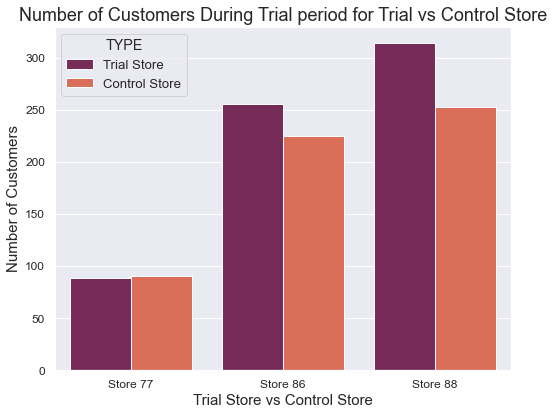

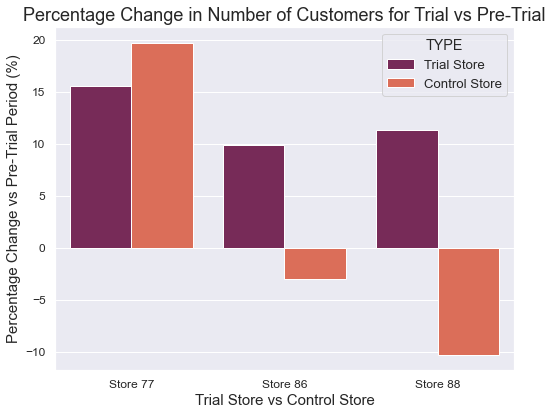

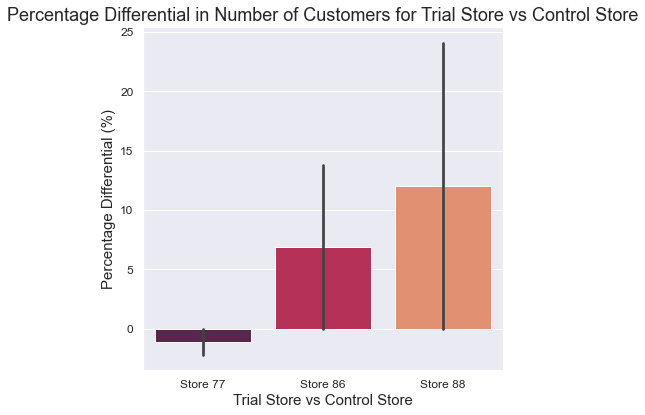

In [215]:
# plotting the results

# Number of Customers during Trial Period
plt.figure(figsize = (8,6))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = 'TRIAL_STORE', y = 'TRIAL_CUST', data = comparison_cust, hue = 'TYPE', palette = 'rocket')
ax.set_xlabel('Trial Store vs Control Store', fontsize = 15)
ax.set_ylabel('Number of Customers', fontsize = 15)
ax.axes.set_title('Number of Customers During Trial period for Trial vs Control Store', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

# % Change compared to pre-trial period
plt.figure(figsize = (8,6))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = 'TRIAL_STORE', y = '%_CHANGE', data = comparison_cust, hue = 'TYPE', palette = 'rocket')
ax.set_xlabel('Trial Store vs Control Store', fontsize = 15)
ax.set_ylabel('Percentage Change vs Pre-Trial Period (%)', fontsize = 15)
ax.axes.set_title('Percentage Change in Number of Customers for Trial vs Pre-Trial', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

# % Differential of sales for Trial Store vs Control Store
plt.figure(figsize = (8,6))
ax = sns.set_style('darkgrid')
ax = sns.barplot(x = 'TRIAL_STORE', y = '%_DIFFERENCE', data = comparison_cust, palette = 'rocket')
ax.set_xlabel('Trial Store vs Control Store', fontsize = 15)
ax.set_ylabel('Percentage Differential (%)', fontsize = 15)
ax.axes.set_title('Percentage Differential in Number of Customers for Trial Store vs Control Store', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

We see that 2/3 stores were able to increase their number of customers higher than that of their corresponding control store. Similarly, those same stores were the only ones capable of having a higher percentage change in number of customers compared to it's control store coutnerpart. 

- Trial store 77 did not see a percentage increase higher than its control store, and during the trail had 2.2% less customers.
- Trial stores 86 and 88 did see significant increases in customers over the trial period compared to their control stores, having percentage differentials of 13.78% and 24.11% respectively.

Let's see if the differences are significant for each store, by comparing distributions and running T-Tests. The null hypothesis for our t_test will be that there is no significant difference between the control store and the trial store for the length of the trial.

In [232]:
# Get proper distributions of customers by value_counting date then scaling by scalers

def create_trial_customer_distribution_df(trial_store):
    dictionary = dict(trial_store['real_date'].value_counts().sort_index())
    df = pd.DataFrame.from_dict(dictionary, orient = 'index', columns = ['customers'])
    return df

def create_scaled_control_distribution_df(control_store, scaler):
    dictionary = dict(control_store['real_date'].value_counts().sort_index())
    df = pd.DataFrame.from_dict(dictionary, orient = 'index', columns = ['customers'])
    df['customers'] = df['customers'] * scaler
    return df

# trial stores
trial_77_cust_dist = create_trial_customer_distribution_df(trial_77)
trial_86_cust_dist = create_trial_customer_distribution_df(trial_86)
trial_88_cust_dist = create_trial_customer_distribution_df(trial_88)

# control stores
trial_233_cust_dist = create_scaled_control_distribution_df(trial_233, scaling_factors[0])
trial_67_cust_dist = create_scaled_control_distribution_df(trial_67, scaling_factors[1])
trial_165_cust_dist = create_scaled_control_distribution_df(trial_165, scaling_factors[2])

In [244]:
def compare_trial_period_distributions(trial, control, store):
    plt.figure(figsize = (8,6))
    ax1 = sns.histplot(trial['customers'])
    ax2 = sns.histplot(control['customers'], color = 'red', alpha = 0.4)
    plt.axvline(np.mean(trial['customers']), color = 'b', linestyle = 'dashed', linewidth = 2)
    plt.axvline(np.mean(control['customers']), color = 'red', linestyle = 'dashed', linewidth = 2)
    _, max_ = plt.ylim()
    plt.text(
        trial['customers'].mean() + trial['customers'].mean() / 10,
        max_ - max_ / 5,
        "Trial Store Mean: {:.2f}".format(trial['customers'].mean())
    )

    _, max_ = plt.ylim()
    plt.text(
        control['customers'].mean() + control['customers'].mean() / 10,
        max_ - max_ / 6,
        "Control Store Mean: {:.2f}".format(control['customers'].mean())
    )
    plt.xlabel('Number of Customers', fontsize = 12)
    plt.title(f'Number of Daily Customers Distribution Comparison, Trial Store {store} vs Control Store', fontsize = 15)
    plt.legend(['Trial Store', 'Control Store'], loc = 'right')

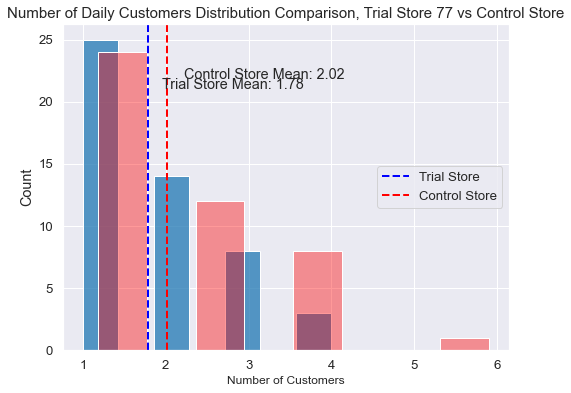

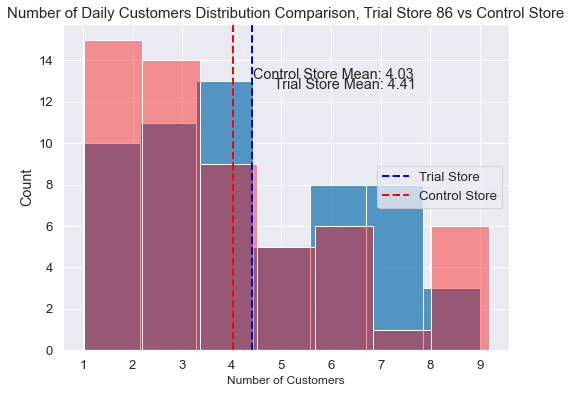

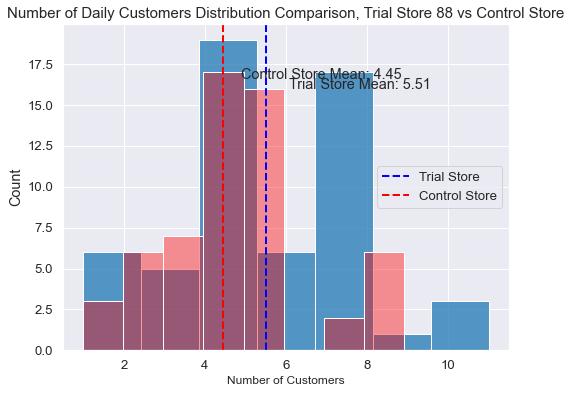

In [245]:
trial_store_dfs = [trial_77_cust_dist, trial_86_cust_dist, trial_88_cust_dist]
control_store_dfs = [trial_233_cust_dist, trial_67_cust_dist, trial_165_cust_dist]
stores = [77, 86, 88]

for trial, control, store in zip(trial_store_dfs, control_store_dfs, stores):
    compare_trial_period_distributions(trial, control, store)

Now that we've compared the distributions, and seen that they are different, we will confirm the significance of the difference using the t-test with a null hypothesis being that there is no difference.

In [262]:
# Performing the T-Test
sample_size = 10

# Store 77
store_77_cust_sampled = np.random.choice(trial_77_cust_dist['customers'], sample_size)
store_233_cust_sampled = np.random.choice(trial_233_cust_dist['customers'], sample_size)

compare_2_groups(store_77_cust_sampled, store_233_trial_sampled, 0.05, sample_size)

Statistics = -6.071, p=0.000
Different distributions (reject H0)


In [270]:
# Store 86
store_86_cust_sampled = np.random.choice(trial_86_cust_dist['customers'], sample_size)
store_67_cust_sampled = np.random.choice(trial_67_cust_dist['customers'], sample_size)

compare_2_groups(store_86_cust_sampled, store_67_trial_sampled, 0.05, sample_size)

Statistics = -2.135, p=0.037
Different distributions (reject H0)


In [273]:
# Store 88
store_88_cust_sampled = np.random.choice(trial_88_cust_dist['customers'], sample_size)
store_165_cust_sampled = np.random.choice(trial_165_cust_dist['customers'], sample_size)

compare_2_groups(store_88_cust_sampled, store_165_trial_sampled, 0.05, sample_size)

Statistics = -2.783, p=0.007
Different distributions (reject H0)


Our t-tests resulted in all trial stores being significantly different from their control store's distributions.

Let's visualize the customers of the trial and control stores over the trial period to see how different they are.

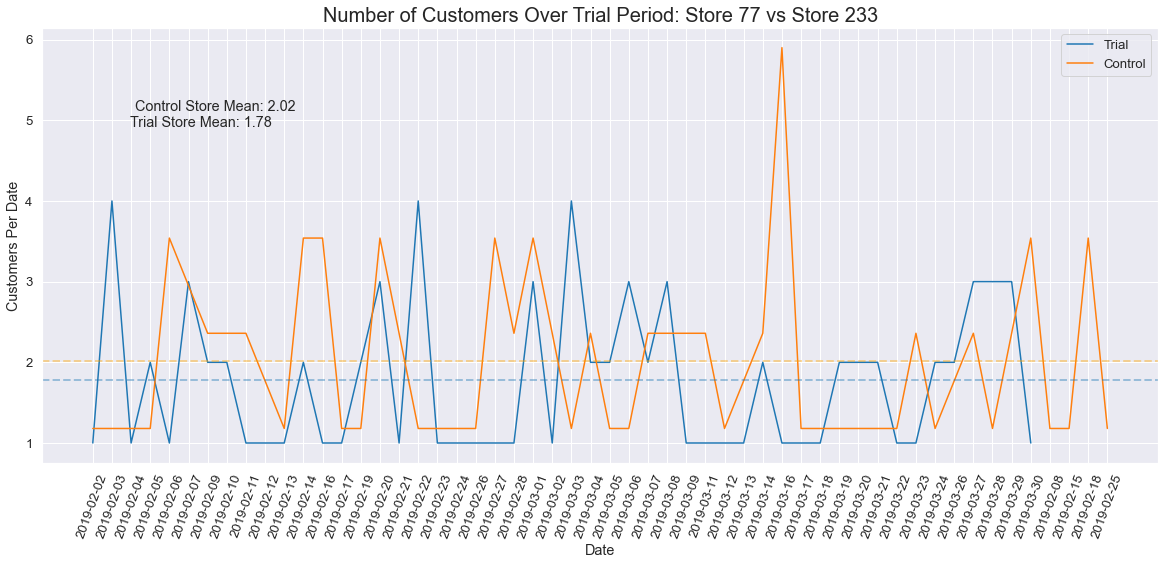

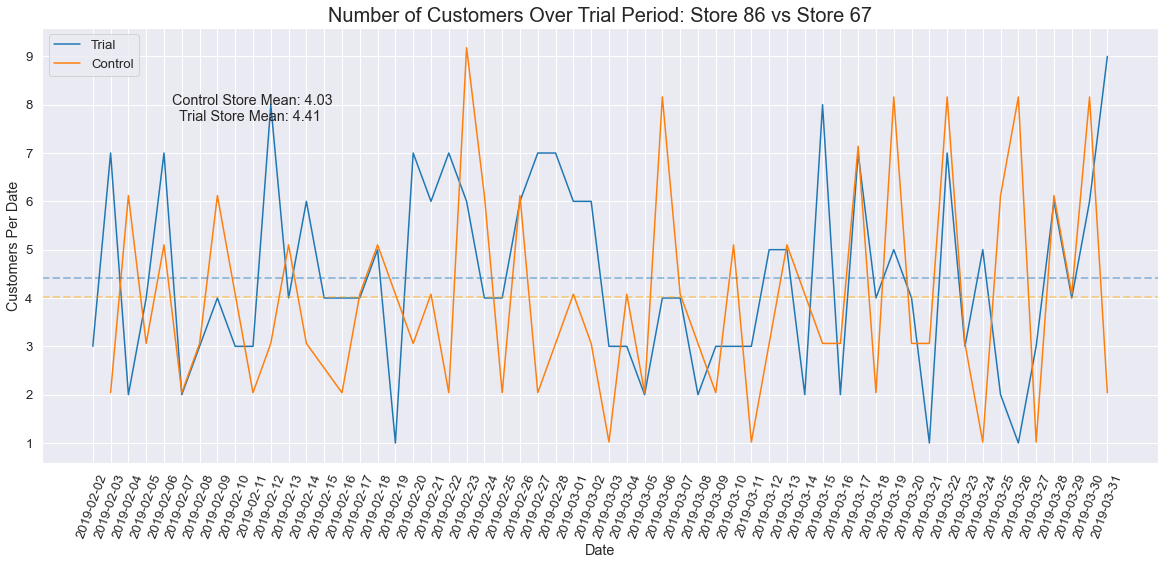

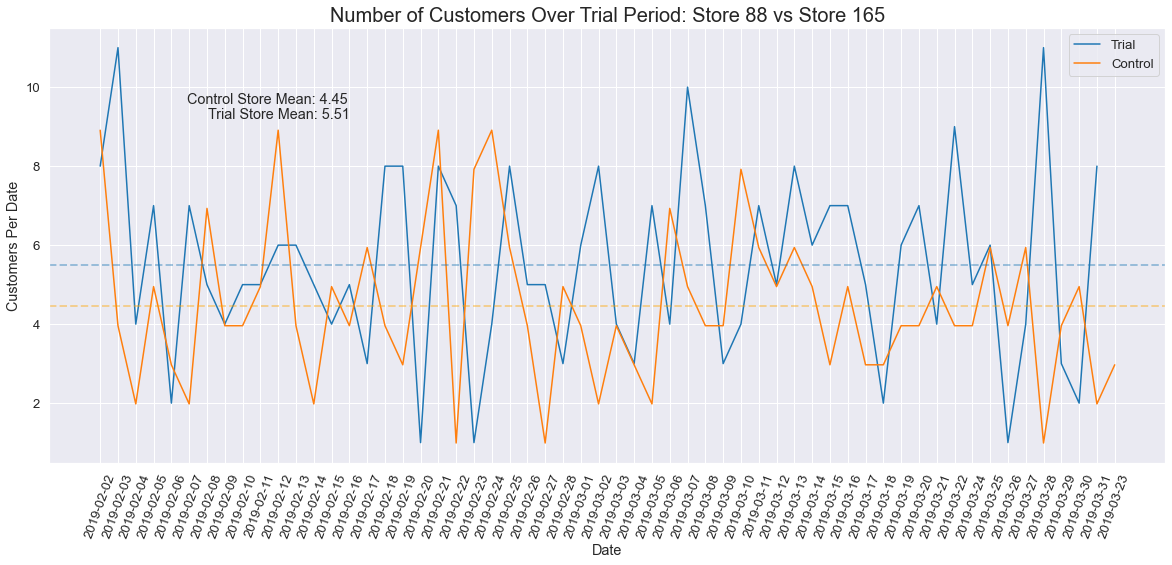

In [288]:
def plot_difference_cust(trial, control, trial_store, control_store):
    plt.figure(figsize = (20,8))
    sns.set_style('darkgrid')
    sns.set_context('notebook', font_scale = 1.2)
    sns.lineplot( x = trial.index, y = trial['customers'], palette = 'rocket')
    sns.lineplot( x = control.index, y = control['customers'], palette = 'rocket')
    plt.axhline(np.mean(trial['customers']), linestyle = 'dashed', linewidth = 2, alpha = 0.4)
    plt.axhline(np.mean(control['customers']), linestyle = 'dashed', color = 'orange', linewidth = 2, alpha = 0.4)
    _, max_ = plt.ylim()
    plt.text(
        trial['customers'].mean() + trial['customers'].mean() / 10,
        max_ - max_ / 5,
        "Trial Store Mean: {:.2f}".format(trial['customers'].mean())
    )

    _, max_ = plt.ylim()
    plt.text(
        control['customers'].mean() + control['customers'].mean() / 10,
        max_ - max_ / 6,
        "Control Store Mean: {:.2f}".format(control['customers'].mean())
    )
    plt.xlabel('Date')
    plt.ylabel('Customers Per Date')
    plt.title(f'Number of Customers Over Trial Period: {trial_store} vs {control_store}', fontsize = 20)
    plt.legend(['Trial', 'Control'])
    plt.xticks(rotation = 70)
    
plot_difference_cust(trial_77_cust_dist, trial_233_cust_dist, 'Store 77', 'Store 233')
plot_difference_cust(trial_86_cust_dist, trial_67_cust_dist, 'Store 86', 'Store 67')
plot_difference_cust(trial_88_cust_dist, trial_165_cust_dist, 'Store 88', 'Store 165')

# Summary DataFrame

In [317]:
summary_df = comparison[['TYPE', 'PRE_TRIAL_SALES', 'TRIAL_SALES', '%_CHANGE','%_DIFFERENCE']]
summary_df.rename(columns = {'%_CHANGE': 'SALES_%_CHANGE',
                            '%_DIFFERENCE': 'SALES_%_DIFFERENTIAL'}, inplace = True)
summary_df['PRE_TRIAL_CUST'] = comparison_cust['PRE_TRIAL_CUST']
summary_df['TRIAL_CUST'] = comparison_cust['TRIAL_CUST']
summary_df['CUST_%_CHANGE'] = comparison_cust['%_CHANGE']
summary_df['CUST_%_DIFFERENTIAL'] = comparison_cust['%_DIFFERENCE']
summary_df

,TYPE,PRE_TRIAL_SALES,TRIAL_SALES,SALES_%_CHANGE,SALES_%_DIFFERENTIAL,PRE_TRIAL_CUST,TRIAL_CUST,CUST_%_CHANGE,CUST_%_DIFFERENTIAL
STORE_NBR,,,,,,,,,
77,Trial Store,413.3,455.70,10.26,-7.48,77,89,15.58,-2.20
233,Control Store,414.0,492.53,18.97,0.00,76,91,19.74,0.00
86,Trial Store,1602.0,1799.60,12.33,14.36,233,256,9.87,13.78
67,Control Store,1605.1,1573.66,-1.96,0.00,232,225,-3.02,0.00
88,Trial Store,2449.8,2752.60,12.36,22.89,282,314,11.35,24.11
165,Control Store,2454.4,2239.88,-8.74,0.00,282,253,-10.28,0.00


# Store 77
In terms of total sales, the results from our t-test showed that the trial in store 77 is significantly different to its control store in the trial period, as the trial store performance lies outside the 5% to 95% confidence interval of the control store. This means that the trial did have an effect, however, the results show a negative return. Compared to its control store, which had a percentage increase in sales of 18.97% from the pre-trial period, the trial negatively impacted store 77’s performance over the trial period. We saw a sales increase of 10.26% compared to its pre-trial performance, however, we also see a negative sales differential of -7.48%. this means that trial store 77 did 7.48% worse in terms of sales over the trial period in comparison to control store 233. For customers, we also see that our t-test for store 77 showed its distribution of customers significantly different to its control store in the trial period, having a p-value lower than 0.05, meaning there was less than a 5% chance that the number of customers were from the same distribution as the control store. Similarly, to total sales, we saw that store 77 had a positive percentage increase in number of customers over the trial period compared to the pre-trial period, being an increase of 15.58%. However, again we saw that in comparison to the control store, the trial had a negative effect, resulting in 2.2% less customers than the control store 233. Overall, the trial was unsuccessful in store 77.

# Store 86
For total sales in store 86, our t-test highlighted that the stores performance during the trial lay within the 5% to 95% confidence interval. Despite this, store 86 had a significant sales increase of 12.33% over the trial compared to the pre-trial period, with a percentage differential of 14.36% higher sales than its control store 67. With the t-test in mind, this large difference in sales can be attributed to the higher number of customers over the trial. Our T-test for number of customers saw that the performance lay outside the 5% to 95% confidence interval of the control store. This means that the trial did have a significant effect on the number of customers. Trial store 86 saw a 9.86% increase compared to its pre-trial metrics and saw 13.78% more customers over the trial period compared to control store 67. Overall, the trial was successful in increase the number of customers significantly over the trial period, however sales were not able to significantly increase per transaction. A recommendation is to check with the Category manager whether there were any special offers in the trial store that may have resulted in lower prices, impacting the overall sales statistics. 

# Store 88
Trial store 88 saw a distinguishable increase in sales compared to its pre-trial period. Over the course of the trial, store 88 was able to increase sales by 12.36%, contrasting the control store, which made 8.74% less sales than its pre-trial performance. Additionally, the trial appeared to have a dramatic effect on the stores total sales compared to the control store during the same period. The trial resulted in a percentage differential of 22.89%, meaning that over the course of the trial, store 88 made 22.89% more sales with the changes, compared to store 165 which didn’t involve the trial strategy. Checking for significance using the T-test, the sampled distributions of both the trial store and control store resulted in a p-value of 0.007, meaning that the chance that there was no difference between the distributions of store 88 and 165 is close to zero. In terms of number of customers, our T-test saw that the performance lay outside the 5% to 95% confidence interval of the control store. This means the trial had a significance effect on the number of customers. Compared to the pre-trial period, the trial saw an increase of 11.35% in number of customers for store 88. Similarly, to sales, the trial had a profound effect on number of customers for the period of the trial, compared to its control store, which saw a significant dip in customer volume. Control store 165 saw a decrease of 10.28% compared to its pre-trial period, and when comparing both stores in the trial period, we see trial store 88 having 24.11% more customers than store 165. Overall, the trial was successful in store 88, having had significant increases in sales and number of customers.
